In [3]:
import midynet
import midynet.util.display as display
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import fractions
import json

from matplotlib.lines import Line2D
from thresholds import *
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)

display.setup_dir("./")

plot = midynet.metrics.Statistics.plot

paths_to_figures = [".", "../../../../papers/p-midynet/paper1-mutual_info/figures"]
paths_to_figures = list(map(pathlib.Path, paths_to_figures))
path_to_data = pathlib.Path("../../../../data/midynet-data/figure4")

In [4]:
exp = {}
hg, hx, hgx, hxg, mi = {}, {}, {}, {}, {}
_hx, _hgx, _mi = {}, {}, {}
thresholds = {}
useClipped = False

all_dynamics = ["ising", "sis", "cowan_backward", "cowan_forward"]
for dynamics in all_dynamics:
    path = path_to_data / f"figure4-large-nbinom-{dynamics}"
    print(dynamics, (path / "config.pickle"), (path / "config.pickle").exists())
    if (path / "config.pickle").exists():
        exp[dynamics] = midynet.experiments.Experiment.load_from_file(path / "config.pickle")
        hg[dynamics] = midynet.metrics.Statistics({k: exp[dynamics].metrics["mutualinfo"].data[exp[dynamics].name][f"hg-{k}"] for k in ["mid", "high", "low"]})
        hx[dynamics] = midynet.metrics.Statistics({k: exp[dynamics].metrics["mutualinfo"].data[exp[dynamics].name][f"hx-{k}"] for k in ["mid", "high", "low"]})
        hgx[dynamics] = midynet.metrics.Statistics({k: exp[dynamics].metrics["mutualinfo"].data[exp[dynamics].name][f"hgx-{k}"] for k in ["mid", "high", "low"]})
        hxg[dynamics] = midynet.metrics.Statistics({k: exp[dynamics].metrics["mutualinfo"].data[exp[dynamics].name][f"hxg-{k}"] for k in ["mid", "high", "low"]})
        mi[dynamics] = midynet.metrics.Statistics({k: exp[dynamics].metrics["mutualinfo"].data[exp[dynamics].name][f"mi-{k}"] for k in ["mid", "high", "low"]})
        
        _mi[dynamics] = mi[dynamics].clip(min=0)
        _hx[dynamics] = hxg[dynamics] + _mi[dynamics]
        _hgx[dynamics] = hg[dynamics] - _mi[dynamics]
    N, E = exp[dynamics].config.graph.size, exp[dynamics].config.graph.edge_count.state
    heterogeneity = exp[dynamics].config.graph.heterogeneity
    
with open("thresholds.json", "r") as f:
    thresholds_data = json.load(f)
titles = {
    "ising": r"Glauber", 
    "sis": r"SIS", 
    "cowan_forward": r"Cowan",
    "cowan_backward": r"Cowan"
}
xlabels = {
    "ising": r"Coupling constant $J$", 
    "sis": r"Transmission rate $\lambda$", 
    "cowan_forward": r"Potential gain $\nu$",
    "cowan_backward": r"Potential gain $\nu$"
}

threshold_labels = {
    "ising": r"$J_c$", 
    "sis": r"$\lambda_c$", 
    "cowan_forward": r"$\nu_c^f$",
    "cowan_backward": r"$\nu_c^b$"
}

ising ../../../../data/midynet-data/figure4/figure4-large-nbinom-ising/config.pickle True
sis ../../../../data/midynet-data/figure4/figure4-large-nbinom-sis/config.pickle True
cowan_backward ../../../../data/midynet-data/figure4/figure4-large-nbinom-cowan_backward/config.pickle True
cowan_forward ../../../../data/midynet-data/figure4/figure4-large-nbinom-cowan_forward/config.pickle True


/tmp/ipykernel_26183/1003000649.py:91: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[dynamics].axes.yaxis.set_ticklabels(recon_yticks)
/tmp/ipykernel_26183/1003000649.py:223: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


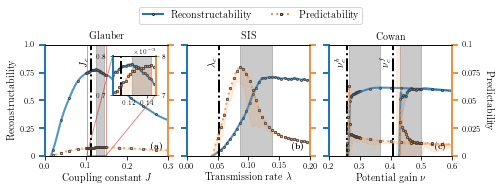

In [5]:
SCALE = 1
fig, _ax = plt.subplots(1, 3, figsize=(SCALE*7,SCALE*7/3), sharex=False, sharey=False)

ax = {dynamics: _ax[i] for i, dynamics in enumerate(all_dynamics[:-1])}
ax["cowan_forward"] = ax["cowan_backward"]
axx = {dynamics: ax[dynamics].twinx() for i, dynamics in enumerate(all_dynamics[:-1])}
axx["cowan_forward"] = axx["cowan_backward"]

color = {
    "recon":display.med_colors["blue"],
    "pred":display.med_colors["orange"],
}

linestyle = {
    "recon":"solid",
    "pred":"dotted",
}

marker = {
    "recon":"o",
    "pred":"s",
}

avgk = 5.
spacing = 7
min_index = 5
recon_yticks = [0, 0.25, 0.5, 0.75, 1.0]
pred_yticks = [0, 0.025, 0.05, 0.075, 0.1]
xlims = {
    "ising": (0,1.5 / avgk),
    "sis": (0,1 / avgk),
    "cowan_forward": (1 / avgk,3 / avgk),
    "cowan_backward": (1 / avgk,3 / avgk),
}

for dynamics_id, dynamics in enumerate(all_dynamics):
    if dynamics not in exp:
        continue
    z = exp[dynamics].config.graph.heterogeneity
    x = exp[dynamics].config.dynamics.get_coupling()
    if dynamics == "sis":
        x = [c / exp[dynamics].config.dynamics.recovery_prob for c in x]
        xxx = x
    m_indices = list(range(min_index)) + list(range(min_index, len(x), spacing))
    if useClipped:
        recon = _mi[dynamics] / hg[dynamics]
        pred = _mi[dynamics] / hx[dynamics]
    else:
        recon = mi[dynamics] / hg[dynamics]
        pred = mi[dynamics] / hx[dynamics]
    x = np.array(x) / avgk
    plot(
        ax[dynamics], 
        x, recon,
        color=color["recon"],
        alpha=0.75,
        linestyle=linestyle["recon"],
        marker=marker["recon"],
        linewidth=2 * SCALE,
        markersize=2 * SCALE,
        markeredgecolor=display.dark_colors["grey"],
        markerfacecolor=display.light_colors["blue"],
        bar=False,
        spacing=1,
        interpolate="quadratic",
    )
    
    plot(
        axx[dynamics], 
        x, pred,
        color=color["pred"],
        alpha=0.75,
        linestyle=linestyle["pred"],
        marker=marker["pred"],
        linewidth=2 * SCALE,
        markersize=2 * SCALE,
        markeredgecolor=display.dark_colors["grey"],
        markerfacecolor=display.med_colors["orange"],
        bar=False,
        spacing=1,
        interpolate="quadratic",
    )
    maxReconIndex = np.argmax(recon["mid"])
    maxPredIndex = np.argmax(pred["mid"])
    
    minParam, maxParam = np.sort([x[maxReconIndex], x[maxPredIndex]])
    ax[dynamics].axvspan(minParam, maxParam, color=display.med_colors["grey"], alpha=0.3)
    
    if dynamics_id == 0:
        ax[dynamics].set_ylabel(r"Reconstructability", fontsize=SCALE * display.fontsizes["large"])
        ax[dynamics].axes.yaxis.set_ticklabels(recon_yticks)
        
    else:
        ax[dynamics].axes.yaxis.set_ticklabels([])
    if dynamics_id == 3:
        axx[dynamics].set_ylabel(r"Predictability", fontsize=SCALE * display.fontsizes["large"], rotation=-90, rotation_mode="anchor", va="bottom")
        axx[dynamics].axes.yaxis.set_ticklabels(pred_yticks)
    else:
        axx[dynamics].axes.yaxis.set_ticklabels([])
        
    ax[dynamics].set_xlabel(xlabels[dynamics], fontsize=SCALE * display.fontsizes["large"])
    ax[dynamics].set_yticks(recon_yticks)
    ax[dynamics].tick_params(axis='both', labelsize=SCALE * display.fontsizes["medium"])
    
    ax[dynamics].set_xlim(xlims[dynamics])
    ax[dynamics].set_ylim(0, 1)
    ax[dynamics].set_title(titles[dynamics], fontsize=SCALE * display.fontsizes["large"])
    
    axx[dynamics].tick_params(axis='both', labelsize=SCALE * display.fontsizes["medium"])
    axx[dynamics].set_ylim(0.0, 0.1)
    axx[dynamics].set_yticks(pred_yticks)
    
    
    ax[dynamics].tick_params(axis='y', color=color["recon"], length=6, width=2)
    axx[dynamics].spines['left'].set_color(color["recon"])
    axx[dynamics].spines['left'].set_linewidth(2)
    axx[dynamics].spines['right'].set_color(color["pred"])
    axx[dynamics].spines['right'].set_linewidth(2)
    axx[dynamics].tick_params(axis='y', color=color["pred"], length=6, width=2)
    t = np.mean(thresholds_data[dynamics]["thresholds"]) / avgk
    ax[dynamics].axvline(t, color="black", linestyle="-.", linewidth=2 * SCALE)
    
    aaa = (xlims[dynamics][1] - xlims[dynamics][0]) / 100
    ax[dynamics].text(t - 2 * aaa, 0.8, 
                      threshold_labels[dynamics], 
                      fontsize=SCALE * display.fontsizes["large"], 
                      rotation=90, 
                      horizontalalignment="right",
                      va="bottom",
                     )
    
    
    if dynamics == "ising":
        axins = ax[dynamics].inset_axes([0.55, 0.55, 0.35, 0.35])
        xmin, xmax = 0.5 / avgk, 0.8 / avgk
        axxins = axins.twinx()
        xx = np.array(x)
        index = np.where(np.logical_and(xx>xmin, xx<xmax))[0]
        plot(
            axins, 
            xx[index], recon[index],
            color=color["recon"],
            alpha=0.75,
            linestyle=linestyle["recon"],
            marker=marker["recon"],
            linewidth=2 * SCALE,
            markersize=2 * SCALE,
            markeredgecolor=display.dark_colors["grey"],
            markerfacecolor=display.light_colors["blue"],
            bar=False,
        )

        plot(
            axxins, 
            xx[index], pred[index],
            color=color["pred"],
            alpha=0.75,
            linestyle=linestyle["pred"],
            marker=marker["pred"],
            linewidth=2 * SCALE,
            markersize=2 * SCALE,
            markeredgecolor=display.dark_colors["grey"],
            markerfacecolor=display.med_colors["orange"],
            bar=False,
        )
        axins.set_ylim([0.7, 0.8])
        axxins.set_ylim([0.007, 0.008])
        axxins.ticklabel_format(axis='y', style='sci', scilimits=(-3,-3))
        axins.set_yticks([0.7, 0.8])
        axxins.set_yticks([0.007, 0.008])
        axxins.spines['left'].set_color(color["recon"])
        axxins.spines['left'].set_linewidth(2)
        axxins.spines['right'].set_color(color["pred"])
        axxins.spines['right'].set_linewidth(2)
        
        axins.tick_params(axis='both', length=3, width=1, labelsize=SCALE*display.fontsizes["small"], color=color["recon"])
        axxins.tick_params(axis='both', length=3, width=1, labelsize=SCALE*display.fontsizes["small"], color=color["pred"])
        axxins.yaxis.offsetText.set_fontsize(SCALE*display.fontsizes["small"])
        
        axins.axvspan(minParam, maxParam, color=display.med_colors["grey"], alpha=0.3)
        axins.axvline(thresholds_data[dynamics]["thresholds"][-1] / avgk, color="black", linestyle="-.", linewidth=2 * SCALE)
        
        axins.set_xlim([xx[index[0]], xx[index[-1]]])
        ax[dynamics].indicate_inset_zoom(axxins, edgecolor=display.dark_colors["red"])
        ax[dynamics].axvline(axins.get_xlim()[0], linestyle="-", color=display.med_colors["red"], alpha=0.5, linewidth=1)
        ax[dynamics].axvline(axins.get_xlim()[1], linestyle="-", color=display.med_colors["red"], alpha=0.5, linewidth=1)

    

for dynamics in all_dynamics[:-1]:
    display.Label.plot(ax[dynamics], loc="bottom right", fontsize=SCALE * display.fontsizes["medium"], box=True)
display.Label.clear()


handles = [
    Line2D(
        [0], [0], 
        marker=marker["recon"], 
        linestyle=linestyle["recon"], 
        color=color["recon"], 
        label=r"Reconstructability", 
        linewidth=2*SCALE, 
        markersize=2 * SCALE, 
        markeredgecolor=display.dark_colors["grey"],
        markerfacecolor=display.light_colors["blue"],
    )
]
handles += [
    Line2D(
        [0], [0], 
        marker=marker["pred"], 
        linestyle=linestyle["pred"], 
        color=color["pred"], 
        label=r"Predictability", 
        linewidth=2*SCALE,
        markersize=2 * SCALE, 
        markeredgecolor=display.dark_colors["grey"],
        markerfacecolor=display.med_colors["orange"]
    )
]
lg = fig.legend(handles=handles, loc="center", fontsize=SCALE*display.fontsizes["large"], ncol=2, bbox_to_anchor=(0.5, 1.05))

plt.tight_layout()
plt.subplots_adjust(wspace=0.15)
if SCALE==1:
    for p in paths_to_figures:
        fig.savefig(p / "svg/p1-figure4.svg", bbox_extra_artists=(lg,), bbox_inches='tight')
        fig.savefig(p / "pdf/p1-figure4.pdf", bbox_extra_artists=(lg,), bbox_inches='tight')
        fig.savefig(p / "png/p1-figure4.png", bbox_extra_artists=(lg,), bbox_inches='tight')